In [ ]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem

from openbabel import openbabel, pybel

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dgl
import dgl.function as fn
from dgl.data import DGLDataset
import dgl.nn as dglnn
from dgl.dataloading import GraphDataLoader

import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import pickle

# This notebook requires torch >= 2.0
torch.__version__

'2.2.2'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
DATA_PATH = os.path.join(os.getcwd(),"data")
MODEL_FOLDER = os.path.join(os.getcwd(),"models")
TRAIN_FILE = os.path.join(DATA_PATH, "train_with_more_features.csv")
TEST_FILE = os.path.join(DATA_PATH, "test_with_more_features.csv")
STRUCTURES_FOLDER = os.path.join(DATA_PATH, "structures")

train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)
# train_structures_data = pd.read_csv(os.path.join(DATA_PATH, "augmented_train_structures.csv"), index_col=0)
# test_structures_data = pd.read_csv(os.path.join(DATA_PATH, "augmented_test_structures.csv"), index_col=0)

## Enfoque 1: Red neuronal de grafos solo a partir de las parejas de átomos ya existentes en el dataset
Para ello, no voy a definir una matriz de adyacencia, voy a utilizar los índices de los átomos para construir los grafos a partir de las interacciones que predecir.
Va a ser un grafo "simple" y bidireccional para poder contabilizar la simetría de la interacción. El objetivo del problema va a ser una regresión de arista. El enfoque va a ser de un modelo general, no especialista en tipo.
De este modo puedo utilizar los datos ya preparados directamente, solo tengo que escalarlos y preparar toda la información por grafo.

In [ ]:
### In order to prototype the model, we'll work on a random set of the train molecules to generate a small train set and validation set
train = train.drop(columns=["mol_name"])

mol_names = train["molecule_name"].unique()
train_labels, val_labels = train_test_split(mol_names, test_size=0.2, random_state=42)

train_mols = train[train["molecule_name"].isin(train_labels)]
val_mols = train[train["molecule_name"].isin(val_labels)]

In [ ]:
### Next step will be to transform categorical variables into a format understandable for our neural network
train_mols = pd.get_dummies(train_mols, columns=["atom_1"], drop_first=True)
train_mols = pd.get_dummies(train_mols, columns=["atom_0"])

val_mols = pd.get_dummies(val_mols, columns=["atom_1"], drop_first=True)
val_mols = pd.get_dummies(val_mols, columns=["atom_0"])

J_type_encoder = LabelEncoder()
hybridization_encoder = LabelEncoder()

train_mols["type"] = J_type_encoder.fit_transform(train_mols["type"])
train_mols["hybridization_1"] = hybridization_encoder.fit_transform(train_mols["hybridization_1"])
train_mols["hybridization_0"] = hybridization_encoder.transform(train_mols["hybridization_0"])

val_mols["type"] = J_type_encoder.transform(val_mols["type"])
val_mols["hybridization_1"] = hybridization_encoder.transform(val_mols["hybridization_1"])
val_mols["hybridization_0"] = hybridization_encoder.transform(val_mols["hybridization_0"])

In [ ]:
### Next, let's scale numerical columns and Scalar Coupling Constant
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

numerical_columns = ["x_0", "y_0", "z_0", "AtomicMass_0", "Electronegativity_0", "AtomicRadius_0", "IonizationEnergy_0", "GasteigerCharge_0",
                     "x_1", "y_1", "z_1", "AtomicMass_1", "Electronegativity_1", "AtomicRadius_1", "IonizationEnergy_1", "GasteigerCharge_1",
                     "nuclear_distance", "xx_distance", "yy_distance", "zz_distance", "centroid_x", "centroid_y", "centroid_z", "pair_to_centroid_distance", "angle", "dihedral"]

train_mols[numerical_columns] = feature_scaler.fit_transform(train_mols[numerical_columns])
val_mols[numerical_columns] = feature_scaler.transform(val_mols[numerical_columns])

# Reshaping so we can fit the scaler
train_mols["scalar_coupling_constant"] = target_scaler.fit_transform(train_mols["scalar_coupling_constant"].values.reshape(-1, 1))
val_mols["scalar_coupling_constant"] = target_scaler.transform(val_mols["scalar_coupling_constant"].values.reshape(-1, 1))

# Flattening again to keep original dimensionality:
train_mols["scalar_coupling_constant"] = train_mols["scalar_coupling_constant"].to_numpy()
val_mols["scalar_coupling_constant"] = val_mols["scalar_coupling_constant"].to_numpy()

In [ ]:
### Construcción del Dataset:

class SCCDataset(DGLDataset):
    def __init__(self, data, dataset_type, force_reload=False):
        self.data = data
        self.dataset_type = dataset_type
        self.graphs = None
        self.incompatible_mols = None
        super(SCCDataset, self).__init__(name="SCCDataset")

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

    def process(self):
        self.graphs, self.incompatible_mols = self._generate_graphs()

    def _generate_graphs(self):
        graphs = []
        incompatible_mols = []

        data_grouped_by_mol = self.data.groupby("molecule_name")

        total_groups = len(data_grouped_by_mol)

        for idx, (mol_name, couplings) in enumerate(data_grouped_by_mol):
            if idx % 100 == 0:
                print(f'\rProgress {idx}/{total_groups} molecules processed', end="", flush=True)

            # Generating the lists of pairs of atoms (source, destination) that will form each edge:
            bond_src_atom = couplings["atom_index_0"]
            bond_dst_atom = couplings["atom_index_1"]

            # Transform data into tensors of a compatible dtype.
            bond_src_atom = torch.tensor(bond_src_atom.values, dtype=torch.int64)
            bond_dst_atom = torch.tensor(bond_dst_atom.values, dtype=torch.int64)

            # The graph will be created from the sources-destinations lists
            g = dgl.graph((bond_src_atom, bond_dst_atom))

            # As scalar coupling interactions are symmetric, we'll build bidirectional edges
            g = dgl.add_reverse_edges(g)

            num_nodes = g.num_nodes()

            # Getting node features from the dataset:
            atom_0_feature_names = ["atom_index_0", "x_0", "y_0", "z_0", "AtomicMass_0", "Electronegativity_0", "AtomicRadius_0", "IonizationEnergy_0", "GasteigerCharge_0", "hybridization_0"]
            atom_1_feature_names = ["atom_index_1", "x_1", "y_1", "z_1", "AtomicMass_1", "Electronegativity_1", "AtomicRadius_1", "IonizationEnergy_1", "GasteigerCharge_1", "hybridization_1"]

            atom_0_features = couplings[atom_0_feature_names]
            atom_1_features = couplings[atom_1_feature_names]

            # Renaming columns to same property so we can concatenate the features:
            atom_0_features = atom_0_features.rename(columns={col: col.rsplit("_",1)[0] for col in atom_0_features.columns})
            atom_1_features = atom_1_features.rename(columns={col: col.rsplit("_",1)[0] for col in atom_1_features.columns})

            # Concatenate all features by row and delete node duplicates
            node_features = pd.concat([atom_0_features, atom_1_features], axis=0)
            node_features = node_features.sort_values(by="atom_index").reset_index(drop=True)
            node_features = node_features.drop_duplicates(subset="atom_index")
            node_features = node_features.set_index("atom_index")

            # Convert to compatible dtype (float32):
            node_features_tensor = torch.tensor(node_features.values, dtype=torch.float32)

            num_node_features = node_features.shape[0]

            if num_nodes != num_node_features:
                incompatible_mols.append(mol_name)
                continue

            # Adding node features to the graph:
            g.ndata["node_feats"] = node_features_tensor

            # Adding edge features to the graph:
            edge_feature_names = ["atom_index_0", "atom_index_1", "scalar_coupling_constant", "type",
                                  "nuclear_distance", "xx_distance", "yy_distance", "zz_distance",
                                  "centroid_x", "centroid_y", "centroid_z", "pair_to_centroid_distance", "angle", "dihedral"]
            direct_edge_features = couplings[edge_feature_names]
            reverse_edge_features = direct_edge_features.copy()
            reverse_edge_features["atom_index_1"], reverse_edge_features["atom_index_0"] = reverse_edge_features["atom_index_0"], reverse_edge_features["atom_index_1"]

            edge_features = pd.concat([direct_edge_features, reverse_edge_features])

            label = edge_features["scalar_coupling_constant"]
            label_tensor = torch.tensor(label.values, dtype=torch.float32)  # Convert label to float32

            edge_type_tensor = torch.tensor(edge_features["type"].values, dtype=torch.int64)

            edge_features = edge_features.drop(["atom_index_0", "atom_index_1", "scalar_coupling_constant", "type"], axis=1)
            edge_features_tensor = torch.tensor(edge_features.values, dtype=torch.float32)  # Convert edge features to float32

            if g.num_edges() != edge_features.shape[0]:
                incompatible_mols.append(mol_name)
                continue

            g.edata["edge_feats"] = edge_features_tensor

            # Adding the edge target_feature (label) as well
            g.edata["label"] = label_tensor

            # Adding self-loops in order to preserve original node features during message-passing
            g = dgl.add_self_loop(g, fill_data="sum")

            graphs.append(g)

        print(f'\rAll molecules processed', end="", flush=True)
        return graphs, incompatible_mols

    def save(self):
        graph_path = os.path.join(MODEL_FOLDER, f"{self.dataset_type}_graphs.bin")
        dgl.save_graphs(graph_path, self.graphs)

    def load(self):
        graph_path = os.path.join(MODEL_FOLDER, f"{self.dataset_type}_graphs.bin")
        self.graphs, _ = dgl.load_graphs(graph_path)

    def has_cache(self):
        graph_path = os.path.join(MODEL_FOLDER, f"{self.dataset_type}_graphs.bin")
        return os.path.exists(graph_path)

In [ ]:
train_data = SCCDataset(data=train_mols, dataset_type="train")

In [ ]:
val_data = SCCDataset(data=val_mols, dataset_type="val")

In [ ]:
train_data[6].ndata["node_feats"].shape

torch.Size([11, 9])

In [ ]:
train_loader = GraphDataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)
val_loader = GraphDataLoader(val_data, batch_size=32, drop_last=False)

In [ ]:
### Defining EarlyStopping callback

class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, verbose=True):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement
            delta (float): Minimum change in validation loss to qualify as improvement
            verbose (bool): Activate / deactivate printed updates about early stopping.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved to val_loss:.4f")

            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement for {self.counter} epochs.")
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f"Early stopping triggered after {self.patience} epochs.")

## Model 1: GraphSAGE convolutional network with 2 layer MLP predictor

### Model Definition

In [ ]:
# Construct the Message Passing Neural Network model
# Each layer in this network will perform one step of message passing
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, num_layers):
        super().__init__()
        self.num_layers = num_layers

        self.convs = nn.ModuleList()
        # First layer:
        self.convs.append(dglnn.SAGEConv(in_feats, hid_feats, aggregator_type='mean'))

        #Intermediate layers
        for _ in range(num_layers - 2):
            self.convs.append(dglnn.SAGEConv(hid_feats, hid_feats, aggregator_type="mean"))

        # last layer
        self.convs.append(dglnn.SAGEConv(hid_feats, out_feats, aggregator_type="mean"))

    def forward(self, graph, inputs):
        h = inputs

        for i in range(self.num_layers - 1):
            h = self.convs[i](graph, h)
            h = F.relu(h)

        h = self.convs[-1](graph, h)
        return h

In [ ]:
class EdgePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(2 * input_dim, hidden_dim) # Will concatenate source and target node embeddings
        self.fc2 = nn.Linear(hidden_dim, output_dim) # Will output edge regression score
        self.relu = nn.ReLU()

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata["h"] = h
            graph.apply_edges(self.compute_edge_score)
            return graph.edata["score"]

    def compute_edge_score(self, edges):
        src, dst = edges.src['h'], edges.dst["h"]
        concatenated_features = torch.cat([src, dst], dim=-1)
        edge_score = self.fc2(self.relu(self.fc1(concatenated_features)))
        return {'score': edge_score}

In [ ]:
# Putting it all together:
class GraphSAGE(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, embedding_features, predictor_hidden_dim, num_layers):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, embedding_features, num_layers)
        self.pred = EdgePredictor(embedding_features, predictor_hidden_dim, out_features)

    def forward(self, g, x):
        x = x.to(torch.float32)
        h = self.sage(g, x)
        return self.pred(g, h)

Epoch 0: Progress 242/242 batches processed
Epoch 0, Training Loss: 0.5542301981646426, Validation Loss: 0.44933294979887334
Validation loss improved to val_loss:.4f
Epoch 1: Progress 242/242 batches processed
Epoch 1, Training Loss: 0.4013182691724224, Validation Loss: 0.37517071599179025
Validation loss improved to val_loss:.4f
Epoch 2: Progress 242/242 batches processed
Epoch 2, Training Loss: 0.37321935444577564, Validation Loss: 0.3585982331821403
Validation loss improved to val_loss:.4f
Epoch 3: Progress 242/242 batches processed
Epoch 3, Training Loss: 0.34330734750022107, Validation Loss: 0.3178595106013599
Validation loss improved to val_loss:.4f
Epoch 4: Progress 242/242 batches processed
Epoch 4, Training Loss: 0.31241334746895527, Validation Loss: 0.2959846253562677
Validation loss improved to val_loss:.4f
Epoch 5: Progress 242/242 batches processed
Epoch 5, Training Loss: 0.2971764344317004, Validation Loss: 0.2945431978580667
Epoch 6: Progress 242/242 batches processed
Ep

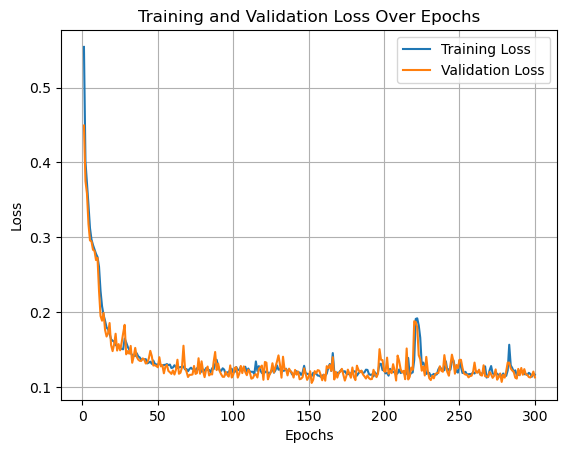

In [ ]:
### Train loop
NUM_EPOCHS = 300
IN_FEATURES = 9 # Number of node features
HIDDEN_FEATURES = 64
EMBEDDING_FEATURES = 16
OUT_FEATURES = 1
NUM_MPNN_LAYERS = 5

model = GraphSAGE(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, embedding_features=EMBEDDING_FEATURES, out_features=OUT_FEATURES, predictor_hidden_dim=HIDDEN_FEATURES, num_layers=NUM_MPNN_LAYERS)
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.L1Loss()
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    total_train_loss = 0

    model.train()

    for idx, batch in enumerate(train_loader):
        batch = batch.to(device)
        node_feats = batch.ndata["node_feats"].to(device)
        labels = batch.edata['label'].to(device)

        # forward pass
        edge_preds = model(batch, node_feats)
        edge_preds = edge_preds.squeeze()

        # compute loss
        loss = loss_fn(edge_preds, labels)

        # backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

        print(f'\rEpoch {epoch}: Progress {idx + 1}/{len(train_loader)} batches processed', end="", flush=True)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            node_feats = batch.ndata["node_feats"].to(device)
            labels = batch.edata['label'].to(device)

            # Forward pass
            edge_preds = model(batch, node_feats)
            edge_preds = edge_preds.squeeze()

            # Compute val loss
            loss = loss_fn(edge_preds, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'\nEpoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    # Checking for early stopping:
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Stopping early")
        break

    if (epoch + 1) % 10 == 0:
        model_save_path = os.path.join(MODEL_FOLDER, f'GraphSAGE_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved to {model_save_path}')

plt.figure()
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1,NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

## Model 2: Graph Attention Network

In [ ]:
# Construct the Message Passing Neural Network model
# Each layer in this network will perform one step of message passing
class GAT(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, num_layers, num_heads):
        super().__init__()
        self.layers = nn.ModuleList()
        # Input layer
        self.layers.append(
            dglnn.GATConv(in_feats, hid_feats, num_heads, activation=F.relu)
        )
        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(dglnn.GATConv(hid_feats * num_heads, hid_feats, num_heads, activation=F.relu))
        # Output layer
        self.layers.append(dglnn.GATConv(hid_feats * num_heads, out_feats, num_heads, activation=None))


    def forward(self, graph, inputs):
        h = inputs
        for layer in self.layers[:-1]:
            h = layer(graph, h)
            h = h.flatten(1) # Flatten the multi-head attention output
        h = self.layers[-1](graph, h)
        h = h.flatten(1)
        return h

In [ ]:
class EdgePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata["h"] = h
            graph.apply_edges(self.compute_edge_score)
            return graph.edata["score"]

    def compute_edge_score(self, edges):
        src, dst = edges.src['h'], edges.dst['h']
        # print(f"Source shape: {src.shape}, Destination shape: {dst.shape}")
        concatenated_features = torch.cat([src, dst], dim=-1)
        # print(f"Concatenated features shape: {concatenated_features.shape}")
        edge_score = self.attention(concatenated_features)
        return {'score': edge_score}

In [ ]:
# Putting it all together:
class GraphGAT(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, embedding_features, predictor_hidden_dim, num_layers, num_heads):
        super().__init__()
        self.gat = GAT(in_features, hidden_features, embedding_features, num_layers, num_heads)
        self.pred = EdgePredictor(input_dim=num_heads*embedding_features, hidden_dim=predictor_hidden_dim, output_dim=1)

    def forward(self, g, x):
        x = x.to(torch.float32)
        h = self.gat(g, x)
        # print(f"GAT output shape: {h.shape}")
        return self.pred(g, h)

Epoch 0: Progress 242/242 batches processed
Epoch 0, Training Loss: 0.5190674772783554, Validation Loss: 0.5058685312566563
Validation loss improved to val_loss:.4f
Epoch 1: Progress 242/242 batches processed
Epoch 1, Training Loss: 0.5098249979527396, Validation Loss: 0.5060450321782519
Epoch 2: Progress 242/242 batches processed
Epoch 2, Training Loss: 0.5090052419654036, Validation Loss: 0.5052914666935356
Epoch 3: Progress 242/242 batches processed
Epoch 3, Training Loss: 0.506375546869338, Validation Loss: 0.49772380374272
Epoch 4: Progress 242/242 batches processed
Epoch 4, Training Loss: 0.4958034059891672, Validation Loss: 0.4114203599673694
Validation loss improved to val_loss:.4f
Epoch 5: Progress 242/242 batches processed
Epoch 5, Training Loss: 0.3927823671139838, Validation Loss: 0.38113027327951615
Validation loss improved to val_loss:.4f
Epoch 6: Progress 242/242 batches processed
Epoch 6, Training Loss: 0.37898995512717465, Validation Loss: 0.37188437610987785
Epoch 7: 

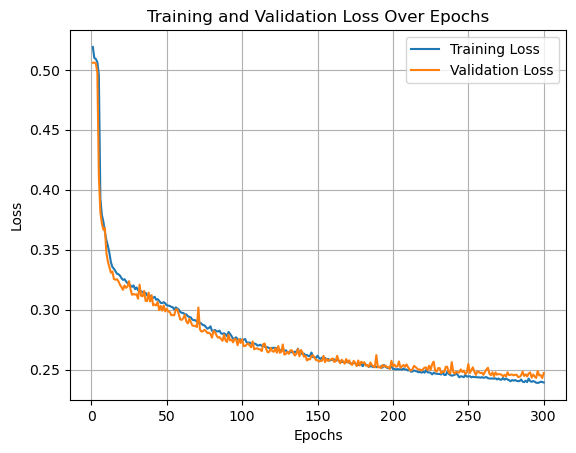

In [ ]:
### Train loop
NUM_EPOCHS = 300
IN_FEATURES = 9 # Number of node features
HIDDEN_FEATURES = 64
EMBEDDING_FEATURES = 16
NUM_HEADS = 4
NUM_MPNN_LAYERS = 5
OUT_FEATURES = 1

model = GraphGAT(in_features=IN_FEATURES,
                 hidden_features=HIDDEN_FEATURES,
                 out_features=OUT_FEATURES,
                 embedding_features=EMBEDDING_FEATURES,
                 predictor_hidden_dim=HIDDEN_FEATURES * NUM_HEADS,
                 num_layers = NUM_MPNN_LAYERS,
                 num_heads = NUM_HEADS
                )
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    total_train_loss = 0

    model.train()

    for idx, batch in enumerate(train_loader):
        batch = batch.to(device)
        node_feats = batch.ndata["node_feats"].to(device)
        labels = batch.edata['label'].to(device)

        # forward pass
        edge_preds = model(batch, node_feats)
        edge_preds = edge_preds.squeeze()

        # compute loss
        loss = loss_fn(edge_preds, labels)

        # backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

        print(f'\rEpoch {epoch}: Progress {idx + 1}/{len(train_loader)} batches processed', end="", flush=True)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            node_feats = batch.ndata["node_feats"].to(device)
            labels = batch.edata['label'].to(device)

            # Forward pass
            edge_preds = model(batch, node_feats)
            edge_preds = edge_preds.squeeze()

            # Compute val loss
            loss = loss_fn(edge_preds, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'\nEpoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    # Checking for early stopping:
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Stopping early")
        break

    if (epoch + 1) % 10 == 0:
        model_save_path = os.path.join(MODEL_FOLDER, f'GraphGAT_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved to {model_save_path}')

plt.figure()
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1,NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

In [ ]:
NUM_EPOCHS = 300
IN_FEATURES = 9 # Number of node features
HIDDEN_FEATURES = 64
EMBEDDING_FEATURES = 16
NUM_HEADS = 4
NUM_MPNN_LAYERS = 5
OUT_FEATURES = 1

SAGE_model_save_path = os.path.join(MODEL_FOLDER, f'GraphSAGE_epoch_300.pth')
GAT_model_save_path = os.path.join(MODEL_FOLDER, f'GraphGAT_epoch_300.pth')

sage_state_dict = torch.load(SAGE_model_save_path)
GAT_state_dict = torch.load(GAT_model_save_path)

model_SAGE = GraphSAGE(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, embedding_features=EMBEDDING_FEATURES, out_features=OUT_FEATURES, predictor_hidden_dim=HIDDEN_FEATURES, num_layers=NUM_MPNN_LAYERS)
model_SAGE.to(device)

model_GAT = GraphGAT(in_features=IN_FEATURES,
                 hidden_features=HIDDEN_FEATURES,
                 out_features=OUT_FEATURES,
                 embedding_features=EMBEDDING_FEATURES,
                 predictor_hidden_dim=HIDDEN_FEATURES * NUM_HEADS,
                 num_layers = NUM_MPNN_LAYERS,
                 num_heads = NUM_HEADS
                )
model_GAT.to(device)

GraphGAT(
  (gat): GAT(
    (layers): ModuleList(
      (0): GATConv(
        (fc): Linear(in_features=9, out_features=256, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
      )
      (1-3): 3 x GATConv(
        (fc): Linear(in_features=256, out_features=256, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
      )
      (4): GATConv(
        (fc): Linear(in_features=256, out_features=64, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
      )
    )
  )
  (pred): EdgePredictor(
    (attention): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=1, 

Mean Absolute Error (MAE): 133.4046


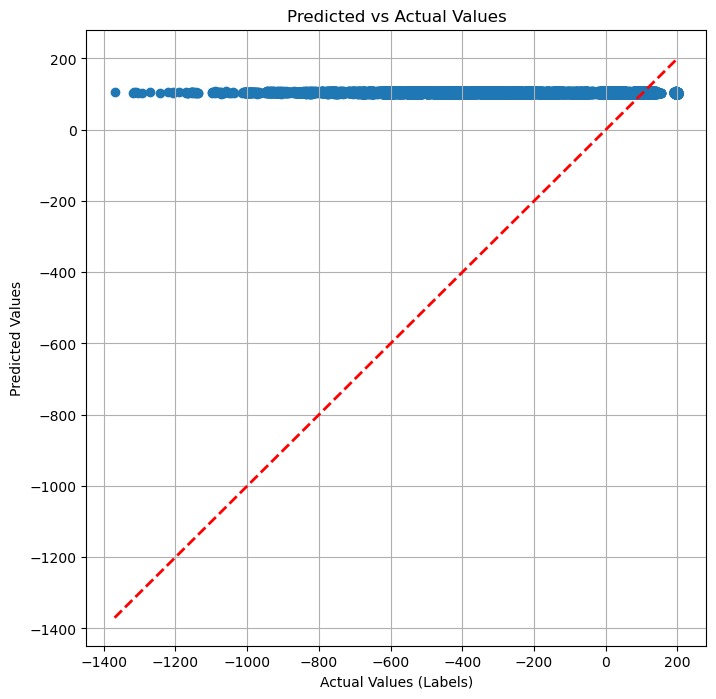

In [ ]:
from sklearn.metrics import mean_absolute_error

# Evaluating with GAT model
model_GAT.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        node_feats = batch.ndata["node_feats"].to(device)
        labels = batch.edata["label"].to(device)

        edge_preds = model_GAT(batch, node_feats)
        edge_preds = edge_preds.squeeze()

        all_labels.append(labels.cpu())
        all_preds.append(edge_preds.cpu())

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

all_labels = target_scaler.inverse_transform(all_labels.reshape(-1, 1)).flatten()
all_preds = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()

mae = mean_absolute_error(all_labels, all_preds)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--', linewidth=2)
plt.xlabel("Actual Values (Labels)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.show()

Mean Absolute Error (MAE): 76.8670


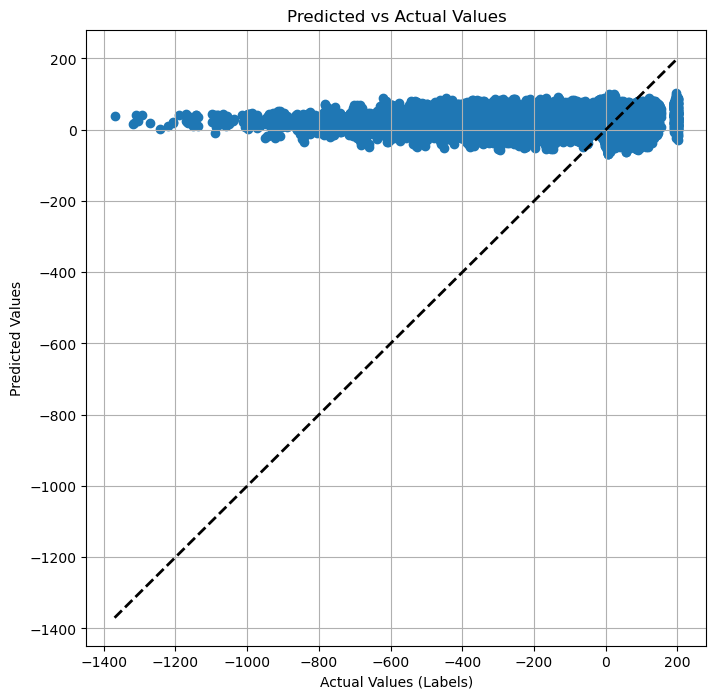

In [ ]:
# Evaluating with SAGE model
model_SAGE.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        node_feats = batch.ndata["node_feats"].to(device)
        labels = batch.edata["label"].to(device)

        edge_preds = model_SAGE(batch, node_feats)
        edge_preds = edge_preds.squeeze()

        all_labels.append(labels.cpu())
        all_preds.append(edge_preds.cpu())

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

all_labels = target_scaler.inverse_transform(all_labels.reshape(-1, 1)).flatten()
all_preds = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()

mae = mean_absolute_error(all_labels, all_preds)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'k--', linewidth=2)
plt.xlabel("Actual Values (Labels)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.show()